# LightGBM training
This is an auto-generated notebook. To reproduce these results, attach this notebook to the **AutoMLCluster** cluster and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/2547542356846121/s?orderByKey=metrics.%60val_f1_score%60&orderByAsc=false)
- Navigate to the parent notebook [here](#notebook/2547542356846122) (If you launched the AutoML experiment using the Experiments UI, this link isn't very useful.)
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

Runtime Version: _10.4.x-cpu-ml-scala2.12_

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "Is_Submitted"

## Load Data

In [0]:
from mlflow.tracking import MlflowClient
import os
import uuid
import shutil
import pandas as pd

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)


# Download the artifact and read it into a pandas DataFrame
input_client = MlflowClient()
input_data_path = input_client.download_artifacts("3cd76bad058748fdae87de1254632771", "data", input_temp_dir)

df_loaded = pd.read_parquet(os.path.join(input_data_path, "training_data"))
# Delete the temp data
shutil.rmtree(input_temp_dir)

# Preview data
df_loaded.head(5)

Out[2]:

,LS_Amount_to_Borrow,LS_GAS,LS_Self_Graded_Credit,Results_From_Wikipedia,Has_Customer_Service,Map_Exists,Unclaimed_Listing,Permanently_Closed,Rating,Number_of_Reviews,Number_of_Results,Mean_monthly_mortgage_and_owner_costs,Rent_mean,Is_established,Number_of_technologies,Average_annual_income_per_household,Average_years_employees_work_at_company,Mean_employee_age,NAICS_sector_code,Company_credit_score,Number_of_socials,Confidence_Score,LS_State,Difference,address,company,Web_Ad_Outlet_code,Web_Ad_Outlet_Source_code,Email_domain,Is_Submitted
0,150000,240000,3,0,0.0,0.0,1.0,0.0,4.8,12.0,6.980000e+05,2121.736895,1172.547380,0.000000,22.0,122256.0,6.5,51.332675,58.198373,51.212596,2.05007,100.0,40,730.000000,0,0,3.0,4.0,0,0
1,15000,150000,2,0,0.0,0.0,1.0,0.0,4.8,12.0,1.120000e+09,1609.921730,1277.785345,0.801759,59.0,106806.0,6.5,51.332675,58.198373,51.212596,2.05007,100.0,3,3658.584025,0,0,3.0,4.0,0,0
2,37500,60000,0,0,0.0,0.0,1.0,0.0,4.8,12.0,8.340000e+06,1644.833498,1048.051495,0.801759,59.0,76624.0,6.5,51.332675,52.000000,51.212596,2.05007,99.0,47,3658.584025,0,0,0.0,1.0,2,0
3,37500,60000,0,0,0.0,0.0,1.0,0.0,4.8,12.0,1.220000e+08,1644.833498,1048.051495,0.801759,59.0,76624.0,6.5,51.332675,58.198373,51.212596,2.05007,100.0,47,3658.584025,0,1,1.0,2.0,0,0
4,7500,150000,0,0,0.0,0.0,1.0,0.0,4.8,12.0,1.670000e+07,1644.833498,1048.051495,0.801759,59.0,76624.0,6.5,51.332675,54.000000,48.000000,2.05007,100.0,47,3658.584025,0,1,0.0,1.0,0,0


### Select supported columns
Select only the columns that are supported. This allows us to train a model that can predict on a dataset that has extra columns that are not used in training.
`["Unclaimed_Listing"]` are dropped in the pipelines. See the Alerts tab of the AutoML Experiment page for details on why these columns are dropped.

In [0]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = ["company", "LS_GAS", "Permanently_Closed", "Difference", "Number_of_Results", "LS_State", "Number_of_Reviews", "Results_From_Wikipedia", "LS_Self_Graded_Credit", "LS_Amount_to_Borrow", "Number_of_technologies", "Rating", "Mean_monthly_mortgage_and_owner_costs", "Number_of_socials", "Rent_mean", "Average_years_employees_work_at_company", "Web_Ad_Outlet_code", "Confidence_Score", "Is_established", "Web_Ad_Outlet_Source_code", "Company_credit_score", "Map_Exists", "Has_Customer_Service", "address", "NAICS_sector_code", "Mean_employee_age", "Average_annual_income_per_household", "Email_domain"]
col_selector = ColumnSelector(supported_cols)

## Preprocessors

In [0]:
transformers = []

### Numerical columns

Missing values for numerical columns are imputed with mean by default.

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

num_imputers = []
num_imputers.append(("impute_mean", SimpleImputer(), ["Average_annual_income_per_household", "Average_years_employees_work_at_company", "Company_credit_score", "Difference", "LS_Amount_to_Borrow", "LS_GAS", "LS_State", "Mean_employee_age", "Mean_monthly_mortgage_and_owner_costs", "NAICS_sector_code", "Number_of_Results", "Number_of_Reviews", "Number_of_technologies", "Rating", "Rent_mean", "Web_Ad_Outlet_code"]))

numerical_pipeline = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors="coerce"))),
    ("imputers", ColumnTransformer(num_imputers, sparse_threshold=0))
])

transformers.append(("numerical", numerical_pipeline, ["Rent_mean", "Average_years_employees_work_at_company", "LS_State", "Number_of_Reviews", "Company_credit_score", "LS_GAS", "LS_Amount_to_Borrow", "Number_of_technologies", "Difference", "NAICS_sector_code", "Web_Ad_Outlet_code", "Mean_employee_age", "Average_annual_income_per_household", "Rating", "Mean_monthly_mortgage_and_owner_costs", "Number_of_Results"]))

### Categorical columns

#### Low-cardinality categoricals
Convert each low-cardinality categorical column into multiple binary columns through one-hot encoding.
For each input categorical column (string or numeric), the number of output columns is equal to the number of unique values in the input column.

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

one_hot_imputers = []

one_hot_pipeline = Pipeline(steps=[
    ("imputers", ColumnTransformer(one_hot_imputers, sparse_threshold=0, remainder="passthrough")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore")),
])

transformers.append(("onehot", one_hot_pipeline, ["Confidence_Score", "Email_domain", "Has_Customer_Service", "Is_established", "LS_Self_Graded_Credit", "Map_Exists", "Number_of_socials", "Permanently_Closed", "Results_From_Wikipedia", "Web_Ad_Outlet_Source_code", "address", "company"]))

In [0]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

### Feature standardization
Scale all feature columns to be centered around zero with unit variance.

In [0]:
from sklearn.preprocessing import StandardScaler

standardizer = StandardScaler()

## Train - Validation - Test Split
Split the input data into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters of the model)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [0]:
from sklearn.model_selection import train_test_split

split_X = df_loaded.drop([target_col], axis=1)
split_y = df_loaded[target_col]

# Split out train data
X_train, split_X_rem, y_train, split_y_rem = train_test_split(split_X, split_y, train_size=0.6, random_state=614601885, stratify=split_y)

# Split remaining data equally for validation and test
X_val, X_test, y_val, y_test = train_test_split(split_X_rem, split_y_rem, test_size=0.5, random_state=614601885, stratify=split_y_rem)

## Train classification model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/2547542356846121/s?orderByKey=metrics.%60val_f1_score%60&orderByAsc=false)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment
- To view the full list of tunable hyperparameters, check the output of the cell below

In [0]:
from lightgbm import LGBMClassifier

help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable, NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None, n_jobs: int = -1, silent: Union[bool, str] = 'warn', importance_type: str = 'split', **kwargs)
 
 LightGBM classifier.
 
 Method resolution order:
 LGBMClassifier
 sklearn.base.ClassifierMixin
 LGBMModel
 sklearn.base.BaseEstimator
 builtins.object
 
 Methods defined here:
 
 fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose='warn', feature_name='auto', categorical_feature='auto', callbacks=None, init_model=None)
 Build a gradient boosting model from the training set (X, y).
 
 Parameters
 ----------
 X : array-like or sparse matrix of shape = [n_samples, n_features]
 Input feature matrix.
 y : array-like of shape = [n_samples]
 The target values (class labels in classification, real numbers in regression).
 sample_weight : array-like of shape = [n_samples] or None, optional (default=None)
 Weights of training data.
 init_score : array-like of shape = [n_samples] or shape = [n_samples * n_classes] (for multi-class task) or shape = [n_samples, n_classes] (for multi-class task) or None, optional (default=None)
 Init score of training data.
 eval_set : list or None, optional (default=None)
 A list of (X, y) tuple pairs to use as validation sets.
 eval_names : list of str, or None, optional (default=None)
 Names of eval_set.
 eval_sample_weight : list of array, or None, optional (default=None)
 Weights of eval data.
 eval_class_weight : list or None, optional (default=None)
 Class weights of eval data.
 eval_init_score : list of array, or None, optional (default=None)
 Init score of eval data.
 eval_metric : str, callable, list or None, optional (default=None)
 If str, it should be a built-in evaluation metric to use.
 If callable, it should be a custom evaluation metric, see note below for more details.
 If list, it can be a list of built-in metrics, a list of custom evaluation metrics, or a mix of both.
 In either case, the ``metric`` from the model parameters will be evaluated and used as well.
 Default: 'l2' for LGBMRegressor, 'logloss' for LGBMClassifier, 'ndcg' for LGBMRanker.
 early_stopping_rounds : int or None, optional (default=None)
 Activates early stopping. The model will train until the validation score stops improving.
 Validation score needs to improve at least every ``early_stopping_rounds`` round(s)
 to continue training.
 Requires at least one validation data and one metric.
 If there's more than one, will check all of them. But the training data is ignored anyway.
 To check only the first metric, set the ``first_metric_only`` parameter to ``True``
 in additional parameters ``**kwargs`` of the model constructor.
 verbose : bool or int, optional (default=True)
 Requires at least one evaluation data.
 If True, the eval metric on the eval set is printed at each boosting stage.
 If int, the eval metric on the eval set is printed at every ``verbose`` boosting stage.
 The last boosting stage or the boosting stage found by using ``early_stopping_rounds`` is also printed.
 
 .. rubric:: Example
 
 With ``verbose`` = 4 and at least one item in ``eval_set``,
 an evaluation metric is printed every 4 (instead of 1) boosting stages.
 
 feature_name : list of str, or 'auto', optional (default=

In [0]:
import mlflow
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline

set_config(display="diagram")

lgbmc_classifier = LGBMClassifier(
  colsample_bytree=0.7458314364406566,
  lambda_l1=1.8593828358605584,
  lambda_l2=0.3701904479666098,
  learning_rate=4.315948263029916,
  max_bin=243,
  max_depth=11,
  min_child_samples=38,
  n_estimators=239,
  num_leaves=9,
  path_smooth=14.257096191768284,
  subsample=0.5488548439204592,
  random_state=614601885,
)

model = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
    ("classifier", lgbmc_classifier),
])

# Create a separate pipeline to transform the validation dataset. This is used for early stopping.
pipeline = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
])

mlflow.sklearn.autolog(disable=True)
pipeline.fit(X_train, y_train)
X_val_processed = pipeline.transform(X_val)

model

Out[11]:

Pipeline Pipeline(steps=[('column_selector',
 ColumnSelector(cols=['company', 'LS_GAS', 'Permanently_Closed',
 'Difference', 'Number_of_Results',
 'LS_State', 'Number_of_Reviews',
 'Results_From_Wikipedia',
 'LS_Self_Graded_Credit',
 'LS_Amount_to_Borrow',
 'Number_of_technologies', 'Rating',
 'Mean_monthly_mortgage_and_owner_costs',
 'Number_of_socials', 'Rent_mean',
 'Average_year...
 ('standardizer', StandardScaler()),
 ('classifier',
 LGBMClassifier(colsample_bytree=0.7458314364406566,
 lambda_l1=1.8593828358605584,
 lambda_l2=0.3701904479666098,
 learning_rate=4.315948263029916, max_bin=243,
 max_depth=11, min_child_samples=38,
 n_estimators=239, num_leaves=9,
 path_smooth=14.257096191768284,
 random_state=614601885,
 subsample=0.5488548439204592))]) ColumnSelector ColumnSelector(cols=['company', 'LS_GAS', 'Permanently_Closed', 'Difference',
 'Number_of_Results', 'LS_State', 'Number_of_Reviews',
 'Results_From_Wikipedia', 'LS_Self_Graded_Credit',
 'LS_Amount_to_Borrow', 'Number_of_technologies', 'Rating',
 'Mean_monthly_mortgage_and_owner_costs',
 'Number_of_socials', 'Rent_mean',
 'Average_years_employees_work_at_company',
 'Web_Ad_Outlet_code', 'Confidence_Score', 'Is_established',
 'Web_Ad_Outlet_Source_code', 'Company_credit_score',
 'Map_Exists', 'Has_Customer_Service', 'address',
 'NAICS_sector_code', 'Mean_employee_age',
 'Average_annual_income_per_household', 'Email_domain']) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('numerical',
 Pipeline(steps=[('converter',
 FunctionTransformer(func= at 0x7f6374d22310>)),
 ('imputers',
 ColumnTransformer(sparse_threshold=0,
 transformers=[('impute_mean',
 SimpleImputer(),
 ['Average_annual_income_per_household',
 'Average_years_employees_work_at_compa...
 ColumnTransformer(remainder='passthrough',
 sparse_threshold=0,
 transformers=[])),
 ('one_hot_encoder',
 OneHotEncoder(handle_unknown='ignore'))]),
 ['Confidence_Score', 'Email_domain',
 'Has_Customer_Service', 'Is_established',
 'LS_Self_Graded_Credit', 'Map_Exists',
 'Number_of_socials', 'Permanently_Closed',
 'Results_From_Wikipedia',
 'Web_Ad_Outlet_Source_code', 'address',
 'company'])]) numerical ['Rent_mean', 'Average_years_employees_work_at_company', 'LS_State', 'Number_of_Reviews', 'Company_credit_score', 'LS_GAS', 'LS_Amount_to_Borrow', 'Number_of_technologies', 'Difference', 'NAICS_sector_code', 'Web_Ad_Outlet_code', 'Mean_employee_age', 'Average_annual_income_per_household', 'Rating', 'Mean_monthly_mortgage_and_owner_costs', 'Number_of_Results'] FunctionTransformer FunctionTransformer(func= at 0x7f6374d22310>) imputers: ColumnTransformer ColumnTransformer(sparse_threshold=0,
 transformers=[('impute_mean', SimpleImputer(),
 ['Average_annual_income_per_household',
 'Average_years_employees_work_at_company',
 'Company_credit_score', 'Difference',
 'LS_Amount_to_Borrow', 'LS_GAS', 'LS_State',
 'Mean_employee_age',
 'Mean_monthly_mortgage_and_owner_costs',
 'NAICS_sector_code', 'Number_of_Results',
 'Number_of_Reviews', 'Number_of_technologies',
 'Rating', 'Rent_mean',
 'Web_Ad_Outlet_code'])]) impute_mean ['Average_annual_income_per_household', 'Average_years_employees_work_at_company', 'Company_credit_score', 'Difference', 'LS_Amount_to_Borrow', 'LS_GAS', 'LS_State', 'Mean_employee_age', 'Mean_monthly_mortgage_and_owner_costs', 'NAICS_sector_code', 'Number_of_Results', 'Number_of_Reviews', 'Number_of_technologies', 'Rating', 'Rent_mean', 'Web_Ad_Outlet_code'] SimpleImputer SimpleImputer() onehot ['Confidence_Score', 'Email_domain', 'Has_Customer_Service', 'Is_established', 'LS_Self_Graded_Credit', 'Map_Exists', 'Number_of_socials', 'Permanently_Closed', 'Results_From_Wikipedia', 'Web_Ad_Outlet_Source_code', 'address', 'company'] imputers: ColumnTransformer ColumnTransformer(remainder='passthrough', sparse_threshold=0, transformers=[]) remainder passthrough passthrough OneHotEncoder OneHotEncoder(handle_unknown='ignore') remainder [['company', 'LS_GA

In [0]:
# Enable automatic logging of input samples, metrics, parameters, and models
mlflow.sklearn.autolog(log_input_examples=True, silent=True)

with mlflow.start_run(experiment_id="2547542356846121", run_name="lightgbm") as mlflow_run:
    model.fit(X_train, y_train, classifier__early_stopping_rounds=5, classifier__eval_set=[(X_val_processed,y_val)], classifier__verbose=False)
    
    # Training metrics are logged by MLflow autologging
    # Log metrics for the validation set
    lgbmc_val_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_val, y_val, prefix="val_")

    # Log metrics for the test set
    lgbmc_test_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_test, y_test, prefix="test_")

    # Display the logged metrics
    lgbmc_val_metrics = {k.replace("val_", ""): v for k, v in lgbmc_val_metrics.items()}
    lgbmc_test_metrics = {k.replace("test_", ""): v for k, v in lgbmc_test_metrics.items()}
    display(pd.DataFrame([lgbmc_val_metrics, lgbmc_test_metrics], index=["validation", "test"]))

/databricks/python/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
 _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/databricks/python/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[LightGBM] [Warning] lambda_l1 is set=1.8593828358605584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8593828358605584
[LightGBM] [Warning] lambda_l2 is set=0.3701904479666098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3701904479666098

precision_score,recall_score,f1_score,accuracy_score,log_loss,roc_auc_score,score
0.7481096294743247,0.8006624510689552,0.7611357683425857,0.8006624510689552,0.5772400188060919,0.6118500204565016,0.8006624510689552
0.7212231888712224,0.7853702588801926,0.7431016752417031,0.7853702588801926,0.6172644263729361,0.576459052476438,0.7853702588801926


In [0]:
# Patch requisite packages to the model environment YAML for model serving
import os
import shutil
import uuid
import yaml

None

import lightgbm
from mlflow.tracking import MlflowClient

lgbmc_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], str(uuid.uuid4())[:8])
os.makedirs(lgbmc_temp_dir)
lgbmc_client = MlflowClient()
lgbmc_model_env_path = lgbmc_client.download_artifacts(mlflow_run.info.run_id, "model/conda.yaml", lgbmc_temp_dir)
lgbmc_model_env_str = open(lgbmc_model_env_path)
lgbmc_parsed_model_env_str = yaml.load(lgbmc_model_env_str, Loader=yaml.FullLoader)

lgbmc_parsed_model_env_str["dependencies"][-1]["pip"].append(f"lightgbm=={lightgbm.__version__}")

with open(lgbmc_model_env_path, "w") as f:
  f.write(yaml.dump(lgbmc_parsed_model_env_str))
lgbmc_client.log_artifact(run_id=mlflow_run.info.run_id, local_path=lgbmc_model_env_path, artifact_path="model")
shutil.rmtree(lgbmc_temp_dir)

## Feature importance

SHAP is a game-theoretic approach to explain machine learning models, providing a summary plot
of the relationship between features and model output. Features are ranked in descending order of
importance, and impact/color describe the correlation between the feature and the target variable.
- Generating SHAP feature importance is a very memory intensive operation, so to ensure that AutoML can run trials without
  running out of memory, we disable SHAP by default.<br />
  You can set the flag defined below to `shap_enabled = True` and re-run this notebook to see the SHAP plots.
- To reduce the computational overhead of each trial, a single example is sampled from the validation set to explain.<br />
  For more thorough results, increase the sample size of explanations, or provide your own examples to explain.
- SHAP cannot explain models using data with nulls; if your dataset has any, both the background data and
  examples to explain will be imputed using the mode (most frequent values). This affects the computed
  SHAP values, as the imputed samples may not match the actual data distribution.

For more information on how to read Shapley values, see the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

In [0]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled =True

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
 0%| | 0/1 [00:00<?, ?it/s]

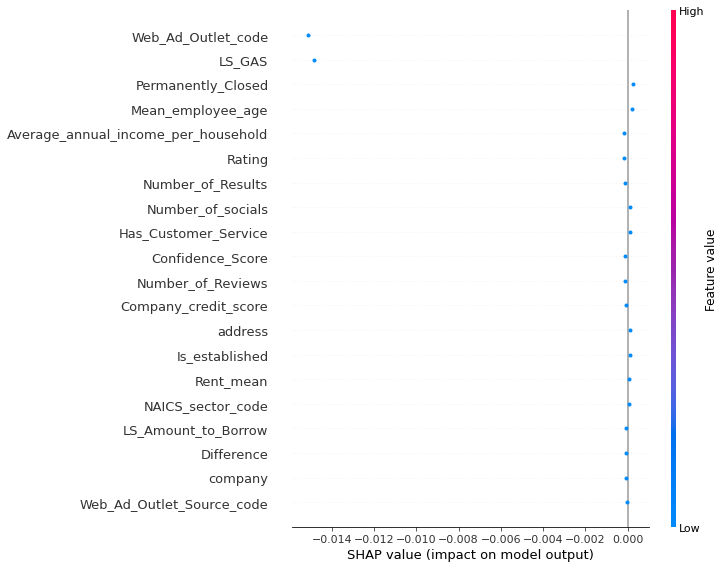

In [0]:
if shap_enabled:
    from shap import KernelExplainer, summary_plot
    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, len(X_train.index)))

    # Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
    example = X_val.sample(n=1)

    # Use Kernel SHAP to explain feature importance on the example from the validation set.
    predict = lambda x: model.predict(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="identity")
    shap_values = explainer.shap_values(example, l1_reg=False)
    summary_plot(shap_values, example, class_names=model.classes_)

In [0]:
from sklearn.ensemble import RandomForestClassifier

help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 
 A random forest classifier.
 
 A random forest is a meta estimator that fits a number of decision tree
 classifiers on various sub-samples of the dataset and uses averaging to
 improve the predictive accuracy and control over-fitting.
 The sub-sample size is controlled with the `max_samples` parameter if
 `bootstrap=True` (default), otherwise the whole dataset is used to build
 each tree.
 
 Read more in the :ref:`User Guide <forest>`.
 
 Parameters
 ----------
 n_estimators : int, default=100
 The number of trees in the forest.
 
 .. versionchanged:: 0.22
 The default value of ``n_estimators`` changed from 10 to 100
 in 0.22.
 
 criterion : {"gini", "entropy"}, default="gini"
 The function to measure the quality of a split. Supported criteria are
 "gini" for the Gini impurity and "entropy" for the information gain.
 Note: this parameter is tree-specific.
 
 max_depth : int, default=None
 The maximum depth of the tree. If None, then nodes are expanded until
 all leaves are pure or until all leaves contain less than
 min_samples_split samples.
 
 min_samples_split : int or float, default=2
 The minimum number of samples required to split an internal node:
 
 - If int, then consider `min_samples_split` as the minimum number.
 - If float, then `min_samples_split` is a fraction and
 `ceil(min_samples_split * n_samples)` are the minimum
 number of samples for each split.
 
 .. versionchanged:: 0.18
 Added float values for fractions.
 
 min_samples_leaf : int or float, default=1
 The minimum number of samples required to be at a leaf node.
 A split point at any depth will only be considered if it leaves at
 least ``min_samples_leaf`` training samples in each of the left and
 right branches. This may have the effect of smoothing the model,
 especially in regression.
 
 - If int, then consider `min_samples_leaf` as the minimum number.
 - If float, then `min_samples_leaf` is a fraction and
 `ceil(min_samples_leaf * n_samples)` are the minimum
 number of samples for each node.
 
 .. versionchanged:: 0.18
 Added float values for fractions.
 
 min_weight_fraction_leaf : float, default=0.0
 The minimum weighted fraction of the sum total of weights (of all
 the input samples) required to be at a leaf node. Samples have
 equal weight when sample_weight is not provided.
 
 max_features : {"auto", "sqrt", "log2"}, int or float, default="auto"
 The number of features to consider when looking for the best split:
 
 - If int, then consider `max_features` features at each split.
 - If float, then `max_features` is a fraction and
 `round(max_features * n_features)` features are considered at each
 split.
 - If "auto", then `max_features=sqrt(n_features)`.
 - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
 - If "log2", then `max_features=log2(n_features)`.
 - If None, then `max_features=n_features`.
 
 Note: the search for a split does not stop until at least one
 valid partition of the node samples is found, even if it requires to
 effectively inspect more than ``max_features`` features.
 
 max_leaf_nodes : int, default=None
 Grow trees with ``max_leaf_nodes`` in best-first fashion.
 Best nodes are defined as relative reduction in impurity.
 If None then unlimited number of leaf nodes.
 
 min_impurity_decrease : float, default=0.0
 A node will be split if this split induces a decrease of the impurity
 greater than or equal to this value.
 
 The weighted impurity decrease equation is the following::
 
 N_t / N * (impurity - N_

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np

from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
 
# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 
 
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]
 

In [0]:
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)
 
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, signature=signature)

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)


Out[19]:

,importance
Number_of_Results,0.119503
Average_annual_income_per_household,0.067908
NAICS_sector_code,0.067690
LS_Amount_to_Borrow,0.065236
LS_GAS,0.062907
Mean_monthly_mortgage_and_owner_costs,0.061668
Rent_mean,0.061177
LS_State,0.052694
Number_of_technologies,0.049583
Difference,0.043114


In [0]:
clf = RandomForestClassifier(random_state = 2)
clf.fit(X_train,y_train)
# y_pred = clf.predict(X_test)  # default threshold is 0.5
y_pred = (clf.predict_proba(X_test)[:,1] >= 0.30).astype(bool) # set threshold as 0.3

In [0]:
import os
import requests
import numpy as np
import pandas as pd

def create_tf_serving_json(data):
  return {'inputs': {name: data[name].tolist() for name in data.keys()} if isinstance(data, dict) else data.tolist()}

def score_model(dataset):
  url = 'https://adb-8618183333104940.0.azuredatabricks.net/model/RandomForestLN/2/invocations'
  headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}'}
  data_json = dataset.to_dict(orient='split') if isinstance(dataset, pd.DataFrame) else create_tf_serving_json(dataset)
  response = requests.request(method='POST', headers=headers, url=url, json=data_json)
  if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
  return response.json()

## Inference
[The MLflow Model Registry](https://docs.databricks.com/applications/mlflow/model-registry.html) is a collaborative hub where teams can share ML models, work together from experimentation to online testing and production, integrate with approval and governance workflows, and monitor ML deployments and their performance. The snippets below show how to add the model trained in this notebook to the model registry and to retrieve it later for inference.

> **NOTE:** The `model_uri` for the model already trained in this notebook can be found in the cell below

### Register to Model Registry
```
model_name = "Example"

model_uri = f"runs:/{ mlflow_run.info.run_id }/model"
registered_model_version = mlflow.register_model(model_uri, model_name)
```

### Load from Model Registry
```
model_name = "Example"
model_version = registered_model_version.version

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")
model.predict(input_X)
```

### Load model without registering
```
model_uri = f"runs:/{ mlflow_run.info.run_id }/model"

model = mlflow.pyfunc.load_model(model_uri)
model.predict(input_X)
```

In [0]:
# model_uri for the generated model
print(f"runs:/{ mlflow_run.info.run_id }/model")

runs:/ebcd2153faf0483e95f5a1cbc944df01/model
